# t-SNE visualization of CIFAR-100 models

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

In [101]:
# visualize t-SNE
def get_tsne(stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    all_features, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, features = model(data)
            all_features.append(features['pooled_feat'].data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    all_features = np.concatenate(all_features, 0)
    all_labels = np.concatenate(all_labels, 0)

    tsne = TSNE(random_state=0)
    all_features = tsne.fit_transform(all_features)
    plot_features(all_features, all_labels, num_classes)

def plot_features(features, labels, num_classes):
    colors = ['C' + str(i) for i in range(num_classes)]
    plt.figure(figsize=(6, 6))
    for l in range(num_classes):
        plt.scatter(
            features[labels == l, 0],
            features[labels == l, 1],
            c=colors[l], s=1, alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


157it [00:18,  8.47it/s]


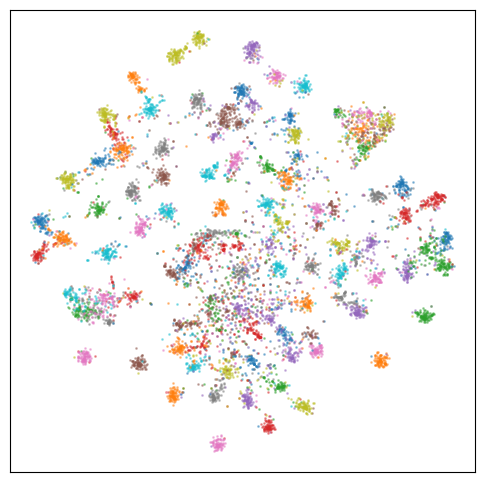

In [102]:
# KD baseline
mpath = "../../download_ckpts/cifar_students/crld_res8x4_7840"
get_tsne("resnet8x4", mpath)
## mpath = "../../download_ckpts/cifar_students/mlld_res8x4_7709"
## get_tsne("resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified


157it [00:19,  7.97it/s]


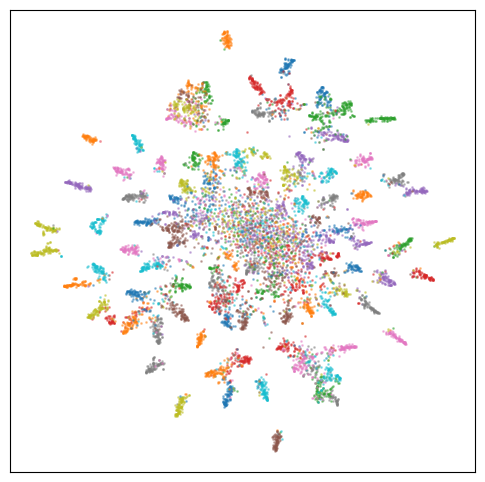

In [100]:
# NormKD
mpath = "../../download_ckpts/cifar_students/normkd_res8x4_7632"
get_tsne("resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified


157it [01:23,  1.88it/s]


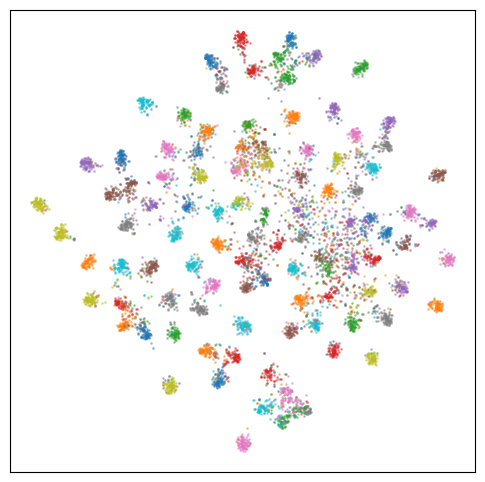

In [15]:
# Our DKD
mpath = "../../download_ckpts/cifar_teachers/resnet32x4_vanilla/ckpt_epoch_240.pth"
get_tsne("resnet32x4", mpath)

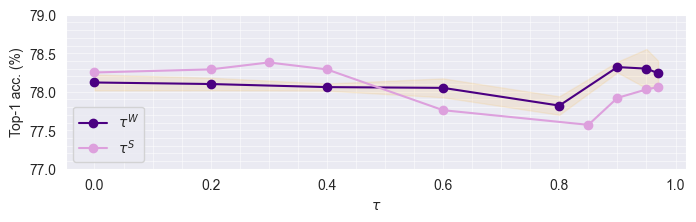

In [65]:
import matplotlib.pyplot as plt
tau_w = [0,     0.2,   0.4,   0.6,   0.8,   0.9,    0.95,  0.97]
y_w =   [78.12, 78.10, 78.06, 78.05, 77.82, 78.32,  78.30, 78.24]
std_w = [0.104, 0.082, 0.046, 0.123, 0.120, 0.0694, 0.255, 0.163]
ub_w = [mean + std for mean, std in zip(y_w, std_w)]
lb_w = [mean - std for mean, std in zip(y_w, std_w)]
tau_s = [0,    0.2,    0.3,   0.4,  0.6,   0.85,   0.9,   0.95,  0.97]
y_s = [78.25, 78.29, 78.38, 78.29, 77.76, 77.57, 77.92, 78.03, 78.06 ]
fig = plt.figure(figsize=(8,2))
plt.plot(tau_w, y_w, marker='o', linestyle='-', color='indigo', label=r'$\tau^W$')
plt.fill_between(tau_w, ub_w, lb_w, color='orange', alpha=0.1)
plt.plot(tau_s, y_s, marker='o', linestyle='-', color='plum', label=r'$\tau^S$')
plt.xlabel(r'$\tau$')
plt.ylabel('Top-1 acc. (%)')
plt.ylim(77,79)
plt.grid(which='both', alpha=0.5) # plt.grid(True)
plt.minorticks_on()
plt.legend()
plt.show()

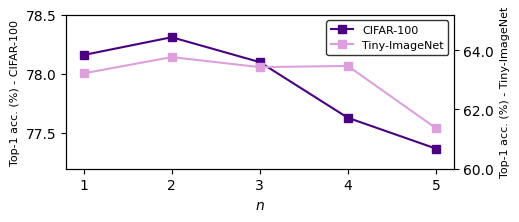

In [4]:
# Sensitivity of n of RandAugment
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
n =   [1,     2,     3,     4,     5]
y_c = [78.16, 78.31, 78.10, 77.63, 77.37] # done
y_t = [63.22, 63.77, 63.43, 63.47, 61.37] # done
fig, ax1 = plt.subplots(figsize=(5,2))
lns1 = ax1.plot(n, y_c, marker='s', color='indigo', label = 'CIFAR-100')
ax1.set_xticks(range(1,6))
ax1.set_xlabel(r'$n$')
ax1.set_ylabel('Top-1 acc. (%) - CIFAR-100', fontsize=8)
ax1.set_ylim(77.2,78.5)
ax2 = ax1.twinx()
lns2 = ax2.plot(n, y_t, marker='s', color='plum', label = 'Tiny-ImageNet')
ax2.set_ylabel('Top-1 acc. (%) - Tiny-ImageNet', fontsize=8)
ax2.set_ylim(60.0,65.2)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lns, labs, loc='upper right',  fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')
# fig = plt.figure(figsize=(8,2))
# plt.plot(tau_w, y_w, marker='o', linestyle='-', color='red', label=r'$\tau^W$')
# plt.fill_between(tau_w, ub_w, lb_w, color='orange', alpha=0.1)
# plt.plot(tau_s, y_s, marker='o', linestyle='-', color='blue', label=r'$\tau^S$')
# plt.grid(which='both', alpha=0.5) # plt.grid(True)
# plt.minorticks_on()
plt.show()

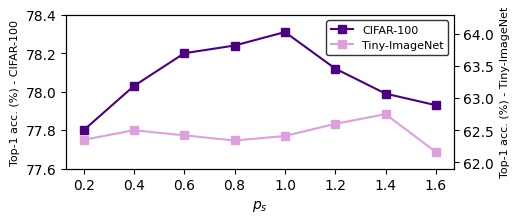

In [2]:
# Sensitivity of p of RandAugment
import matplotlib.pyplot as plt
p =   [0.2,   0.4,   0.6,   0.8,   1.0,   1.2,   1.4,  1.6]
y_c = [77.80, 78.03, 78.20, 78.24, 78.31, 78.12, 77.99, 77.93] # to-do
y_t = [62.35, 62.50, 62.42, 62.34, 62.41, 62.60, 62.75, 62.16] #
fig, ax1 = plt.subplots(figsize=(5,2))
lns1 = ax1.plot(p, y_c, marker='s', color='indigo', label = 'CIFAR-100')
ax1.set_xlabel(r'$p_s$')
ax1.set_ylabel('Top-1 acc. (%) - CIFAR-100', fontsize=8)
ax1.set_ylim(77.6,78.4)
ax2 = ax1.twinx()
lns2 = ax2.plot(p, y_t, marker='s', color='plum', label = 'Tiny-ImageNet')
ax2.set_ylabel('Top-1 acc. (%) - Tiny-ImageNet', fontsize=8)
ax2.set_ylim(61.9,64.3)

# plt.plot(tau_w, y_w, marker='o', linestyle='-', color='indigo', label=r'$\tau^W$')
# plt.fill_between(tau_w, ub_w, lb_w, color='orange', alpha=0.1)
# plt.plot(tau_s, y_s, marker='o', linestyle='-', color='plum', label=r'$\tau^S$')
# plt.xlabel(r'$\tau$')
# plt.ylabel('Top-1 acc. (%)')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lns, labs, loc='upper right',  fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')

# fig = plt.figure(figsize=(8,2))
# plt.plot(tau_w, y_w, marker='o', linestyle='-', color='red', label=r'$\tau^W$')
# plt.fill_between(tau_w, ub_w, lb_w, color='orange', alpha=0.1)
# plt.plot(tau_s, y_s, marker='o', linestyle='-', color='blue', label=r'$\tau^S$')
# plt.grid(which='both', alpha=0.5) # plt.grid(True)
# plt.minorticks_on()
plt.show()

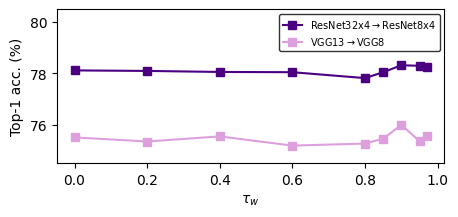

In [82]:
# Sensitivity of tau_w of RandAugment
import matplotlib.pyplot as plt
tau_w = [0.0,   0.2,   0.4,   0.6,   0.8,  0.85,   0.9,   0.95,  0.97]
y_r = [78.12, 78.10, 78.06, 78.05, 77.82, 78.05, 78.32, 78.30, 78.24]
y_v = [75.51, 75.35, 75.55, 75.19, 75.27, 75.46, 76.00, 75.36, 75.55]
fig = plt.figure(figsize=(5,2))
## lns1 = ax1.plot(t_w, y_r, marker='s', color='indigo', label = 'CIFAR-100')
## ax1.set_xlabel(r'$p_s$')
## ax1.set_ylabel('Top-1 acc. (%) - CIFAR-100', fontsize=8)
## ax1.set_ylim(77.6,78.4)
## lns2 = ax2.plot(t_w, y_v, marker='s', color='plum', label = 'Tiny-ImageNet')
## ax2.set_ylabel('Top-1 acc. (%) - Tiny-ImageNet', fontsize=8)
## ax2.set_ylim(7.6,78.4)
plt.plot(tau_w, y_r, marker='s', color='indigo', label=r'ResNet32x4$\rightarrow$ResNet8x4')
plt.plot(tau_w, y_v, marker='s', color='plum', label=r'VGG13$\rightarrow$VGG8')
plt.xlabel(r'$\tau_w$')
plt.ylabel('Top-1 acc. (%)')
plt.ylim(74.5,80.5)
legend = plt.legend(loc='upper right', fontsize=7)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')
plt.show()

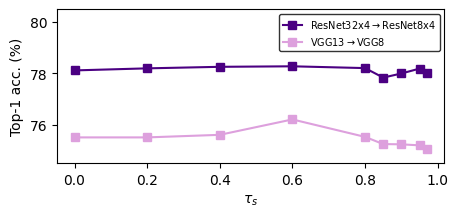

In [81]:
# Sensitivity of tau_s of RandAugment
import matplotlib.pyplot as plt
tau_s = [0.0,   0.1,   0.2,   0.3,   0.4,  0.6,   0.8,   0.9,  0.95]
y_r = [78.12, 78.20, 78.26, 78.28, 78.21, 77.84,  78.00, 78.19, 78.03]
y_v = [75.51, 75.51, 75.61, 76.21, 75.53, 75.25, 75.24, 75.20, 75.06]
fig = plt.figure(figsize=(5,2))
## lns1 = ax1.plot(t_w, y_r, marker='s', color='indigo', label = 'CIFAR-100')
## ax1.set_xlabel(r'$p_s$')
## ax1.set_ylabel('Top-1 acc. (%) - CIFAR-100', fontsize=8)
## ax1.set_ylim(77.6,78.4)
## lns2 = ax2.plot(t_w, y_v, marker='s', color='plum', label = 'Tiny-ImageNet')
## ax2.set_ylabel('Top-1 acc. (%) - Tiny-ImageNet', fontsize=8)
## ax2.set_ylim(7.6,78.4)
plt.plot(tau_w, y_r, marker='s', color='indigo', label=r'ResNet32x4$\rightarrow$ResNet8x4')
plt.plot(tau_w, y_v, marker='s', color='plum', label=r'VGG13$\rightarrow$VGG8')
plt.xlabel(r'$\tau_s$')
plt.ylabel('Top-1 acc. (%)')
plt.ylim(74.5,80.5)
legend = plt.legend(loc='upper right', fontsize=7)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('white')
plt.show()

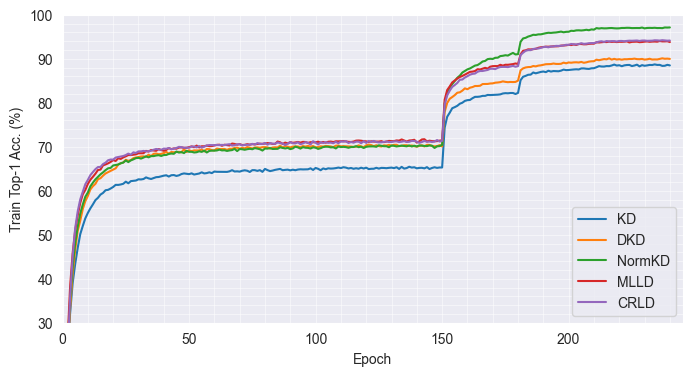

In [4]:
import matplotlib.pyplot as plt
kd_file_path = "../../output/log/kd_res32x4_res8x4_7361.txt"
dkd_file_path = "../../output/log/dkd_res32x4_res8x4_7590.txt"
normkd_file_path = "../../output/log/normkd_res32x4_res8x4_7632.txt"
mlld_file_path = "../../output/log/mlld_res32x4_res8x4_7709.txt"
crld_file_path = "../../output/log/crld_res32x4_res8x4_7865.txt"

kd_train_accs = []
dkd_train_accs = []
normkd_train_accs = []
mlld_train_accs = []
crld_train_accs = []

# Read from KD file
with open(kd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'train_acc:' in line:
            train_acc = float(line.split(':')[1].strip())
            kd_train_accs.append(train_acc)

# Read from KD file
with open(dkd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'train_acc:' in line:
            train_acc = float(line.split(':')[1].strip())
            dkd_train_accs.append(train_acc)

# Read from MLLD file
with open(mlld_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'train_acc:' in line:
            train_acc = float(line.split(':')[1].strip())
            mlld_train_accs.append(train_acc)

# Read from NormKD file
with open(normkd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'train_acc:' in line:
            train_acc = float(line.split(':')[1].strip())
            normkd_train_accs.append(train_acc)

# Read from CRLD file
with open(crld_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'train_acc:' in line:
            train_acc = float(line.split(':')[1].strip())
            crld_train_accs.append(train_acc)

fig = plt.figure(figsize=(8,4))
plt.plot(range(1, len(kd_train_accs)+1), kd_train_accs, linestyle='-', label='KD')
plt.plot(range(1, len(dkd_train_accs)+1), dkd_train_accs, linestyle='-', label='DKD')
plt.plot(range(1, len(normkd_train_accs)+1), normkd_train_accs, linestyle='-', label='NormKD')
plt.plot(range(1, len(mlld_train_accs)+1), mlld_train_accs, linestyle='-', label='MLLD')
plt.plot(range(1, len(crld_train_accs)+1), crld_train_accs, linestyle='-', label='CRLD')
plt.xlabel('Epoch'); plt.ylabel('Train Top-1 Acc. (%)')
plt.xlim(0,245)
plt.ylim(30,100)
plt.grid(which='both', alpha=0.5) # plt.grid(True)
plt.minorticks_on()
plt.legend(loc='lower right')
plt.show()

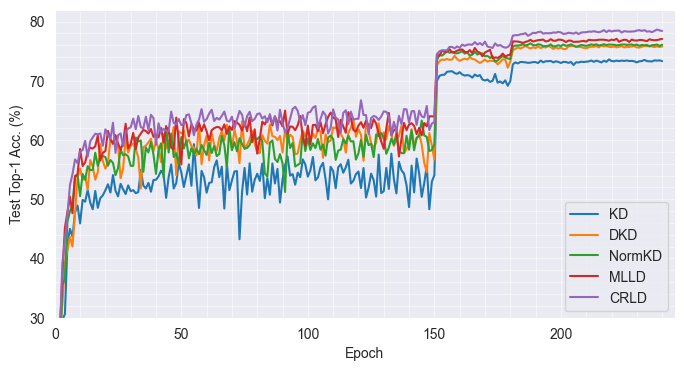

In [7]:
import matplotlib.pyplot as plt
kd_file_path = "../../output/log/kd_res32x4_res8x4_7361.txt"
dkd_file_path = "../../output/log/dkd_res32x4_res8x4_7590.txt"
normkd_file_path = "../../output/log/normkd_res32x4_res8x4_7632.txt"
mlld_file_path = "../../output/log/mlld_res32x4_res8x4_7709.txt"
crld_file_path = "../../output/log/crld_res32x4_res8x4_7865.txt"

kd_test_accs = []
dkd_test_accs = []
normkd_test_accs = []
mlld_test_accs = []
crld_test_accs = []

# Read from KD file
with open(kd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'test_acc:' in line:
            test_acc = float(line.split(':')[1].strip())
            kd_test_accs.append(test_acc)

# Read from KD file
with open(dkd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'test_acc:' in line:
            test_acc = float(line.split(':')[1].strip())
            dkd_test_accs.append(test_acc)

# Read from NormKD file
with open(normkd_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'test_acc:' in line:
            test_acc = float(line.split(':')[1].strip())
            normkd_test_accs.append(test_acc)

# Read from MLLD file
with open(mlld_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'test_acc:' in line:
            test_acc = float(line.split(':')[1].strip())
            mlld_test_accs.append(test_acc)

# Read from CRLD file
with open(crld_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        if 'test_acc:' in line:
            test_acc = float(line.split(':')[1].strip())
            crld_test_accs.append(test_acc)

fig = plt.figure(figsize=(8,4))
plt.plot(range(1, len(kd_test_accs)+1), kd_test_accs, linestyle='-', label='KD')
plt.plot(range(1, len(dkd_test_accs)+1), dkd_test_accs, linestyle='-', label='DKD')
plt.plot(range(1, len(normkd_test_accs)+1), normkd_test_accs, linestyle='-', label='NormKD')
plt.plot(range(1, len(mlld_test_accs)+1), mlld_test_accs, linestyle='-', label='MLLD')
plt.plot(range(1, len(crld_test_accs)+1), crld_test_accs, linestyle='-', label='CRLD')
plt.xlabel('Epoch'); plt.ylabel('Test Top-1 Acc. (%)')
plt.xlim(0,245)
plt.ylim(30,82)
plt.grid(which='both', alpha=0.5) # plt.grid(True)
plt.minorticks_on()
plt.legend(loc='lower right')
plt.show()